# VegET Testing: ipygee

Imports

In [1]:
import datetime
import dateutil.parser
import VegET
from VegET import interpolate, daily_aggregate, utils, veg_et_model
#import cartoee as cee
import matplotlib.pyplot as plt
# import bqplot
import ipyleaflet
import IPython.display
import numpy as np
import pandas as pd
# import traitlets
import ee
# import ipywidgets as widgets
# import ipyleaflet  # an interactive mapping "widget"
# from sidecar import Sidecar
from ipygee import *

Initialize EarthEngine

In [2]:
ee.Initialize()

Define date range

In [3]:
start_date = ee.Date('2001-04-03')
end_date = ee.Date('2003-10-28')   # to account for buffer in DOY calculations
start_year = 2002
end_year = 2018

Define ROI 

In [4]:
# ROI
# roi_fc = ee.FeatureCollection('EPA/Ecoregions/2013/L4');
# polygon = roi_fc.filter(ee.Filter.eq('system:index', '00000a53e3e196f3200c'))
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
polygon = countries.filter(ee.Filter.eq('country_co', 'US'))

# Filter to only include images within the colorado and utah boundaries (from ee-api/python examples)
# polygon = ee.Geometry.Polygon([[
#     [-109.05, 37.0], [-102.05, 37.0], [-102.05, 41.0],   # colorado
#     [-109.05, 41.0], [-111.05, 41.0], [-111.05, 42.0],   # utah
#     [-114.05, 42.0], [-114.05, 37.0], [-109.05, 37.0]]])

Define growing season months as integers. Note, filtering is inclusive.

In [5]:
g_season_begin = 4  # inclusive
g_season_end = 10   # inclusive

**NOTE**: for this case, the imagecollections are global or continent wide rasters. Ordinarily, the
imageCollections would need `.filterBounds()` to the ROI to subset to the images that intersect the
polygon. In this case, the filter does nothing since the images are continent/global scale.

Get ImageCollection used to calculate NDVI values. In this example, MODIS data are used.

In [6]:
ndvi_coll = ee.ImageCollection("MODIS/006/MOD09Q1").filterDate(start_date, end_date)\
    .filter(ee.Filter.calendarRange(g_season_begin, g_season_end, 'month'))\
    .map(lambda f: f.clip(polygon))
ndvi_coll = ndvi_coll.map(VegET.utils.getNDVI)

Get daily climate data (precip, eto, temp)

In [7]:
precip_eto_coll = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start_date, end_date)\
    .select('pr', 'eto', 'tmmn', 'tmmx').filter(ee.Filter.calendarRange(g_season_begin, g_season_end, 'month'))\
    .map(lambda f: f.clip(polygon))

# Add band for calculated mean daily temp
precip_eto_coll = precip_eto_coll.map(VegET.utils.dailyMeanTemp)
# Convert to Celsius
precip_eto_coll = precip_eto_coll.map(VegET.utils.kelvin2celsius).select(['pr', 'eto', 'tminC', 'tmaxC', 'tmeanC'])

VegET static inputs

In [8]:
# Specify canopy intercept image or imageCollection. NOTE: Assumes single band image
canopy_int = ee.Image('users/darin_EE/VegET/Interception').clip(polygon).double().rename('intercept')
# Get static Soil Water Holding Capacity grid (manually uploaded as GEE asset)
whc = ee.Image('users/darin_EE/VegET/WaterHoldingCapacity_mm').clip(polygon).double().rename('whc')
# Get static Soil Saturation image
soil_sat = ee.Image('users/darin_EE/VegET/SoilSaturation_mm').clip(polygon).double().rename('soil_sat')
# Get static Field Capacity image
fcap = ee.Image('users/darin_EE/VegET/FieldCapacity_mm').clip(polygon).double().rename('fcap')

# Create single static image with static inputs as bands
staticImage = canopy_int.addBands([whc, soil_sat, fcap])

Add static data to ndvi_coll as bands

In [9]:
ndvi_coll = ndvi_coll.map(VegET.utils.addStaticBands([staticImage]))

Daily interpolation. Primarily using methods developed in OpenET

In [10]:
# Create daily interpolated ndvi collection
ndvi_daily = interpolate.daily(precip_eto_coll, ndvi_coll)

# Add date band as 'time'
ndvi_daily = ee.ImageCollection(ndvi_daily.map(VegET.utils.add_date_band))

In [11]:
print(ndvi_daily.first().bandNames().getInfo())

['ndvi', 'intercept', 'whc', 'soil_sat', 'fcap', 'pr', 'eto', 'tminC', 'tmaxC', 'tmeanC', 'time']


## Run VegET model

In [12]:
vegET_run = veg_et_model.vegET_model(ndvi_daily, polygon)

In [13]:
dateSelect = vegET_run.filterDate('2002-07-10', '2002-07-11')
image = ee.Image(dateSelect.first().select('swf'))

print(image.bandNames().getInfo())

['swf']


In [14]:
date_range = vegET_run.reduceColumns(ee.Reducer.minMax(), ['system:time_start'])


In [15]:
def GetBand(ee_image):
    new_image = ee_image.select('swf')
    return new_image

In [16]:
swf_coll = vegET_run.map(GetBand)
print(swf_coll.first().bandNames().getInfo())

['swf']


In [17]:
# def GetTileLayerUrl(ee_image_object, list_urls):
#   map_id = ee.Image(ee_image_object).getMapId()
#   tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
#   return ee.List(list_urls.add(tile_url_template.format(**map_id)))


In [18]:
# # Empty list to store urls
# url_list = ee.List([])

In [19]:
# swf_urls = ee.ImageCollection(swf_coll.iterate(GetTileLayerUrl, url_list))

## ipygee: Create a Map instance    

Arguments:   
- tabs: a tuple indicating which tabs to load in the map. Options are: Inspector, Layers, Assets, Tasks   
- kwargs: as this class inherits from ipyleaflet. Map it can accept all its arguments

In [20]:
# Map = Map()

## Show map with method show
- Arguments
    - tabs: show tabs (bool)
    - layer_control: show a control for layers (bool)
    - draw_control: show a control for drawings (bool)
    - fullscrean: show fullscreen button (bool)

In [21]:
# Map.show()

## Resize Map
Dimensions must be in pixel units

In [22]:
# Map.setDimensions('90%', '300px')

## Define visualization parameters

In [23]:
visParam = {'bands': ['swi', 'swe', 'snowpack'], 'min': 0, 'max': 100}
visParamSwf = {'bands': ['swf'], 'min': 0, 'max': 70}

## Add Layers   

In [24]:
# Map.addLayer(image, visParamSwf, name = 'VegET 2003-07-10')
#Map.addLayer(polygon, name = 'ROI')

## Add multiple images from a collection   

In [25]:
# Map.addImageCollection(swf_coll.limit(30), visParamSwf, namePattern = 'VegET results for {system_date}')

## Timeseries plots   

In [26]:
# test_site = ee.Geometry.Point([-102.35768788380938, 46.33412852950776])
# test_feat = ee.Feature(test_site, {'name': 'test feature', 'buffer': 0})
# bands = ['swf', 'pr']

# testColl = vegET_run.filterDate('2003-04-10', '2003-09-30').select(bands)

# chart_ts = chart.Image.series(**{
#     'imageCollection': testColl.limit(120),
#     'region': test_feat,
#     'scale': 10,
#     'bands': bands,
#     'label_bands': bands#,
# #     'properties': ['system:index'],
# #     'label_properties': ['index']
# })

In [27]:
# chart_ts.renderWidget(width = '75%')

In [28]:
# chart_ts.dataframe

## Extract EE object information to dataframe   
source: https://github.com/tylere/AGU2017/blob/master/notebooks/satellite_analysis.ipynb

In [17]:
def GetDataFrame(coll, coords):
    pnt = coords
    #pnt = ee.Geometry.Point(coords)
    # Sample for a time series of values at the point
    geom_values = coll.select(['swf', 'pr', 'ndvi']).getRegion(geometry=pnt, scale=250)
    geom_values_list = ee.List(geom_values).getInfo()
    # Convert to pandas DataFrame
    header = geom_values_list[0]
    data = pd.DataFrame(geom_values_list[1: ], columns=header)
    data['datetime'] = pd.to_datetime(data['time'], unit = 'ms', utc = True)
    data.set_index('time')
    data = data.sort_values('datetime')
    data = data[['datetime', 'swf', 'pr', 'ndvi']]
    return data
                        

In [18]:
test_results = []

In [19]:
# test_site = ee.Geometry.Point([-102.35768788380938, 46.33412852950776])
test_site = ee.Geometry.Point([-99.04523321736421, 43.63408731864001])

# Need to skip the first image since it doesn't have all bands
testColl = vegET_run.filterDate('2002-05-04', '2002-05-28')
# yr = 2001
# filtered = vegET_run.filter(ee.Filter.calendarRange(yr, yr, 'year'))
temp_run = GetDataFrame(testColl, test_site)
test_results.append(temp_run)



# #  Fails due to memory limits
# for yr in range(start_year, end_year + 1):
#     filtered = vegET_run.filter(ee.Filter.calendarRange(yr, yr, 'year'))
#     temp_run = GetDataFrame(filtered, test_site)
#     test_results.append(temp_run)
    
# 8:36:56

EEException: Computation timed out.

In [ ]:
# 9:58
print(test_results)

In [ ]:
results = pd.concat(test_results)

In [ ]:
# # write to csv
# results.to_csv(r'C:\Users\dschult\pycharmProjects\VegET\testing_df.csv')
# # test = GetDataFrame(vegET_run, test_site)

In [ ]:
results.index = pd.to_datetime(results['datetime'])

In [ ]:
print(results.head())

In [ ]:
results.plot(y = ['swf', 'pr'], figsize=(15, 4))

In [35]:
sigs = pd.read_csv(r'C:\Users\dschult\Documents\pycharmProjects\VegET\ndvi_sig_example.csv', index_col = 0)

In [36]:
print(sigs.head())

     open_water  urban_developed    barren  forest_dec  forest_mix  grassland  \
doy                                                                             
96     0.263871         0.264992  0.262767    0.260588    0.254663   0.227242   
104    0.290207         0.291556  0.289753    0.287433    0.276798   0.251231   
112    0.322090         0.323466  0.321927    0.319604    0.305156   0.280963   
120    0.350866         0.353093  0.352574    0.350874    0.340654   0.312596   
128    0.381170         0.383881  0.384523    0.383246    0.371832   0.344275   

     shrubland  wetland_woody  wetland_herb  
doy                                          
96    0.230709       0.220485      0.214649  
104   0.252127       0.244830      0.237188  
112   0.271146       0.279649      0.272246  
120   0.295525       0.315610      0.300945  
128   0.314911       0.362755      0.350550  


## NDVI Signatures Example     

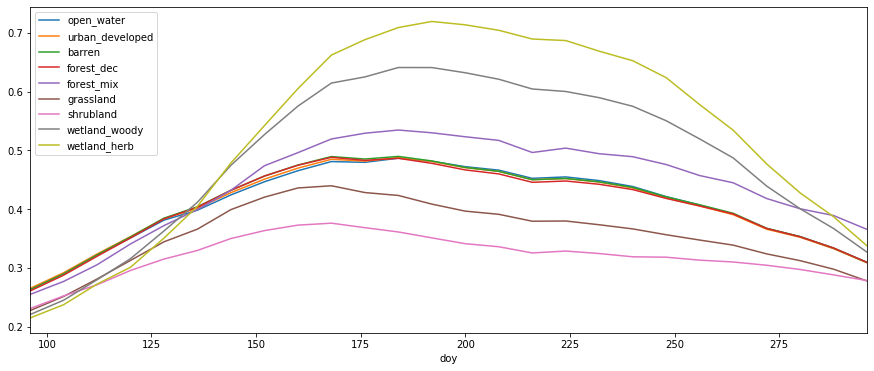

In [37]:
sigs.plot.line(figsize = (15, 6))